In [1]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random
import yaml
from omegaconf import DictConfig, OmegaConf
from interventions import three_operands
from tqdm.notebook import tqdm
import numpy as np
from functools import partial
import pickle

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
import transformer_lens.patching as patching
import seaborn as sns
import matplotlib.pyplot as plt

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)
device = 'cuda'

LABELS = ['operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq', 'res', 'operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq']


def get_logit_diff(logits, answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()


def get_patched_result(item, model, activation_name='resid_pre'):
    clean_logits, clean_cache = model.run_with_cache(item.base_string_tok)
    corrupted_logits = model(item.alt_string_tok)
    
    print(item.base_string_tok)
    print(item.alt_string_tok)

    answer_token_indices = torch.tensor([[item.res_base_tok[0], item.pred_res_alt_tok]]).to(model.cfg.device)

    clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).cpu()
    corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).cpu()

    # def metric(logits, answer_token_indices=answer_token_indices):
    #     return (get_logit_diff(logits, answer_token_indices) - corrupted_logit_diff) / torch.abs(clean_logit_diff - corrupted_logit_diff)
    metric = partial(get_logit_diff, answer_token_indices=answer_token_indices)
    
    if activation_name == 'resid_pre':
        patched_logit_diff = patching.get_act_patch_resid_pre(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'attn_layer':
        patched_logit_diff = patching.get_act_patch_attn_out(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'mlp':
        patched_logit_diff = patching.get_act_patch_mlp_out(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()
    elif activation_name == 'head':
        patched_logit_diff = patching.get_act_patch_attn_head_out_all_pos(model, item.alt_string_tok.to(model.cfg.device), clean_cache, metric).cpu()

    return patched_logit_diff, clean_logit_diff, corrupted_logit_diff


def take_operands_and_operators_results(intervention_list, patched_results, tokenizer):
    all_operators = {'+', '-', '*', 'times', 'minus', 'plus'}
    all_equal_signs = {'=', 'is'}
    
    patched_results_operands_and_operators = []
    for idx, item in enumerate(intervention_list[:len(patched_results)]):
        curr_tokens = [tokenizer.decode(token) for token in item.base_string_tok[0]]
        considered_positions = []
        for position, token in enumerate(curr_tokens):
            if token.strip() in all_operators or token.strip() in all_equal_signs or token.strip().isnumeric():
                considered_positions.append(position)
        patched_results_operands_and_operators.append(patched_results[idx][:, considered_positions])
    return patched_results_operands_and_operators


def compute_macro_mean(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    return (torch.mean(torch.stack(patched_results), dim=0) - torch.tensor(corrupted_logit_diffs).mean()) / (torch.tensor(clean_logit_diffs).mean() - torch.tensor(corrupted_logit_diffs).mean())


def compute_micro_mean(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    # return (torch.mean(torch.stack(patched_results), dim=0) - torch.mean(corrupted_logit_diffs)) / torch.abs(torch.mean(clean_logit_diffs) - torch.mean(corrupted_logit_diffs))
    return torch.mean((torch.stack(patched_results) - torch.tensor(corrupted_logit_diffs)[:, None, None]) / (torch.tensor(clean_logit_diffs)[:, None, None] - torch.tensor(corrupted_logit_diffs)[:, None, None]), dim=0)


def compute_pe(patched_results, clean_logit_diffs, corrupted_logit_diffs):
    return torch.mean(torch.stack(patched_results) - torch.tensor(corrupted_logit_diffs)[:, None, None], dim=0)

/home/scratch_local/esx208-880681/icl_mech_interp/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/scratch_local/esx208-880681/icl_mech_interp/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/scratch_local/esx208-880681/icl_mech_interp/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.

In [2]:
save_directory = '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/patching_results_opt_2_7b/'

In [3]:
def tokenize(item, tokenizer):
    item_base = tokenizer.encode(' ' + item.few_shots.lstrip() + item.base_string)
    item_alt = tokenizer.encode(' ' + item.base_string.lstrip())
    item_alt = [tokenizer.pad_token_id] * (len(item_base) - len(item_alt)) + item_alt
    return torch.tensor(item_base).unsqueeze(0).to(device), torch.tensor(item_alt).unsqueeze(0).to(device)

def tokenize_whitespace(item, tokenizer):
    item_base = tokenizer.encode(' ' + item.few_shots.lstrip() + item.base_string)
    item_alt = tokenizer.encode(' ' + item.base_string.lstrip())
    whitespace = tokenizer.encode(' ', add_special_tokens=False)
    item_alt = whitespace * (len(item_base) - len(item_alt)) + item_alt
    return torch.tensor(item_base).unsqueeze(0).to(device), torch.tensor(item_alt).unsqueeze(0).to(device)

In [15]:
model_name = 'microsoft/Phi-3-mini-4k-instruct'
model_name_lens = 'phi-3'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = HookedTransformer.from_pretrained_no_processing(
    model_name_lens,
    dtype=torch.float16
)
model.eval()
conf = OmegaConf.load('conf/config.yaml')

intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/base_data_arabic_opt_2_7.pkl')

corr_intervention_list = []
for item in intervention_list:
    # input_id_base = item.base_string_tok.to(model.cfg.device)
    # input_id_alt = item.alt_string_tok.to(model.cfg.device)
    input_id_base, input_id_alt = tokenize_whitespace(item, tokenizer)
    # input_id_base, input_id_alt = tokenize(item, tokenizer)

    output_base = model.generate(input_id_base, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
    output_alt = model.generate(input_id_alt, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
    corr_tok = item.res_base_tok[0]

    item.set_predicted_alt_result(pred_alt_string=tokenizer.decode([output_alt]), pred_res_alt_tok=output_alt)
    item.base_string_tok = input_id_base
    item.alt_string_tok = input_id_alt
    if output_base == corr_tok and output_alt != corr_tok:
        corr_intervention_list.append(item)

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:  42%|####2     | 2.10G/4.97G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [17]:
tokenizer.tokenize('12')

['▁', '1', '2']

In [8]:
tokenizer

CodeGenTokenizerFast(name_or_path='microsoft/phi-2', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50257: AddedToken("                               ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50258: AddedToken("                              ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50259: AddedToken("                             ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50260: AddedToken("                            ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50261: AddedToken("            

In [33]:
len(intervention_list)

210

In [34]:
len(corr_intervention_list)

45

In [52]:
all_resid_pre_act_patch_results = []
all_resid_pre_clean_logit_diffs = []
all_resid_pre_corrupted_logit_diffs = []
for item in tqdm(corr_intervention_list):
    patched_logit_diff, clean_logit_diff, corrupted_logit_diff = get_patched_result(item, model)
    all_resid_pre_act_patch_results.append(patched_logit_diff)
    all_resid_pre_clean_logit_diffs.append(clean_logit_diff)
    all_resid_pre_corrupted_logit_diffs.append(corrupted_logit_diff)

  0%|          | 0/45 [00:00<?, ?it/s]

tensor([[   2,  231, 2055,  231, 2055,  195, 5457,  601,    4,  231, 2055,  231,
         2055,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  231, 2055,  231,
         2055,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  262, 2055,  132, 2055,  158, 5457,  753,    4,  231, 2055,  132,
         2055,  204, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  231, 2055,  132,
         2055,  204, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  361, 2055,  204, 2055,  231, 5457,  753,    4,
           20,  898,    9,  290, 2055,  204, 2055,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  290, 2055,  204, 2055,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  262, 2055,  195, 2055,  155, 5457,  379,    4,
           20,  898,    9,  132, 2055,  262, 2055,  231, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 2055,  262, 2055,  231, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  262, 2055,  231, 2055,  132, 5457,  379,    4,
           20,  898,    9,  155, 2055,  155, 2055,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  155, 2055,  155, 2055,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  204, 2055,  158, 2055,  155, 5457,  601,    4,
           20,  898,    9,  158, 2055,  155, 2055,  204, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  158, 2055,  155, 2055,  204, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  204, 2055,  204, 2055,  204, 5457,  316,    4,
           20,  898,    9,  365, 2055,  231, 2055,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  365, 2055,  231, 2055,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[    2,    20,   898,     9,   601, 10877,   204, 10877,   290,    16,
           195,     4,    20,   898,     9,   601, 10877,   195, 10877,   290,
            16]], device='cuda:0')
tensor([[ 1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,     2,    20,   898,     9,   601, 10877,   195, 10877,   290,
            16]], device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[    2,    20,   898,     9,   753, 10877,   316, 10877,   195,    16,
           132,     4,    20,   898,     9,   504, 10877,   155, 10877,   316,
            16]], device='cuda:0')
tensor([[ 1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,  1437,
          1437,     2,    20,   898,     9,   504, 10877,   155, 10877,   316,
            16]], device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  155, 1009,  132, 5457,  316,    4,
           20,  898,    9,  132, 1009,  132, 1009,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  132, 1009,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  155, 1009,  155, 5457,  504,    4,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  155, 1009,  132, 5457,  504,    4,
           20,  898,    9,  132, 1009,  155, 1009,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  155, 1009,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  155, 1009,  132, 5457,  504,    4,
           20,  898,    9,  132, 1009,  132, 1009,  204, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  132, 1009,  204, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  132, 1009,  155, 5457,  504,    4,
           20,  898,    9,  155, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  155, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  155, 1009,  132, 5457,  316,    4,
           20,  898,    9,  132, 1009,  132, 1009,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  132, 1009,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  155, 1009,  132, 5457,  504,    4,
           20,  898,    9,  132, 1009,  204, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  204, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  132, 1009,  132, 5457,  316,    4,
           20,  898,    9,  132, 1009,  132, 1009,  204, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  132, 1009,  204, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  132, 1009,  155, 5457,  316,    4,
           20,  898,    9,  132, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  155, 1009,  132, 5457,  504,    4,
           20,  898,    9,  155, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  155, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  155, 1009,  155, 5457,  504,    4,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  132, 1009,  132, 5457,  290,    4,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  204, 1009,  132, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155, 1009,  132, 1009,  155, 5457,  504,    4,
           20,  898,    9,  132, 1009,  155, 1009,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  155, 1009,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132, 1009,  155, 1009,  132, 5457,  316,    4,
           20,  898,    9,  132, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132, 1009,  155, 1009,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132,  498,  155,  498,  155, 5457,  504,    4,
           20,  898,    9,  155,  498,  155,  498,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  155,  498,  155,  498,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155,  498,  132,  498,  155, 5457,  504,    4,
           20,  898,    9,  155,  498,  155,  498,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  155,  498,  155,  498,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  155,  498,  155,  498,  132, 5457,  504,    4,
           20,  898,    9,  132,  498,  155,  498,  155, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132,  498,  155,  498,  155, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  132,  498,  132,  498,  132, 5457,  290,    4,
           20,  898,    9,  132,  498,  132,  498,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132,  498,  132,  498,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,  204,  498,  132,  498,  132, 5457,  545,    4,
           20,  898,    9,  132,  498,  132,  498,  132, 5457]],
       device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,
           20,  898,    9,  132,  498,  132,  498,  132, 5457]],
       device='cuda:0')


  0%|          | 0/672 [00:00<?, ?it/s]

tensor([[   2,  132, 1009,  132, 1009,  155, 5457,  316,    4,  132, 1009,  132,
         1009,  155, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  132,
         1009,  155, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  132, 1009,  132, 1009,  132, 5457,  290,    4,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  132, 1009,  155, 1009,  132, 5457,  316,    4,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  132, 1009,  132, 1009,  204, 5457,  545,    4,  132, 1009,  204,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  204,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  132, 1009,  132, 1009,  204, 5457,  545,    4,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  132,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  204, 1009,  132, 1009,  132, 5457,  545,    4,  132, 1009,  204,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  204,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  155, 1009,  132, 1009,  155, 5457,  504,    4,  155, 1009,  155,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  155, 1009,  155,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  155, 1009,  155, 1009,  132, 5457,  504,    4,  155, 1009,  155,
         1009,  132, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  155, 1009,  155,
         1009,  132, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,  204, 1009,  132, 1009,  132, 5457,  545,    4,  132, 1009,  132,
         1009,  204, 5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,    2,  132, 1009,  132,
         1009,  204, 5457]], device='cuda:0')


  0%|          | 0/480 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  379,  111,  501, 4839, 1009,  361, 5457,
          361,    4,   20,  898,    9,   36,  379,  111,  501, 4839, 1009,  316,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  379,  111,  501, 4839, 1009,  316,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  504,  111,  601, 4839, 1009,  231, 5457,
          231,    4,   20,  898,    9,   36,  231,  111,  195, 4839, 1009,  155,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  231,  111,  195, 4839, 1009,  155,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  155,  111,  132, 4839, 1009,  545, 5457,
          545,    4,   20,  898,    9,   36,  291,  111,  753, 4839, 1009,  545,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  291,  111,  753, 4839, 1009,  545,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  291,  111,  379, 4839, 1009,  132, 5457,
          158,    4,   20,  898,    9,   36,  504,  111,  501, 4839, 1009,  204,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  504,  111,  501, 4839, 1009,  204,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  291,  111,  753, 4839, 1009,  231, 5457,
          231,    4,   20,  898,    9,   36,  231,  111,  195, 4839, 1009,  501,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  231,  111,  195, 4839, 1009,  501,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  290,  111,  231, 4839, 1009,  155, 5457,
          231,    4,   20,  898,    9,   36,  290,  111,  262, 4839, 1009,  231,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  290,  111,  262, 4839, 1009,  231,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  545,  111,  501, 4839, 1009,  262, 5457,
          501,    4,   20,  898,    9,   36,  155,  111,  132, 4839, 1009,  504,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  155,  111,  132, 4839, 1009,  504,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

tensor([[   2,   20,  898,    9,   36,  365,  111,  158, 4839, 1009,  379, 5457,
          379,    4,   20,  898,    9,   36,  365,  111,  158, 4839, 1009,  501,
         5457]], device='cuda:0')
tensor([[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437,
         1437,    2,   20,  898,    9,   36,  365,  111,  158, 4839, 1009,  501,
         5457]], device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

In [53]:
patched_results_operands_operators = take_operands_and_operators_results(corr_intervention_list, all_resid_pre_act_patch_results, tokenizer)

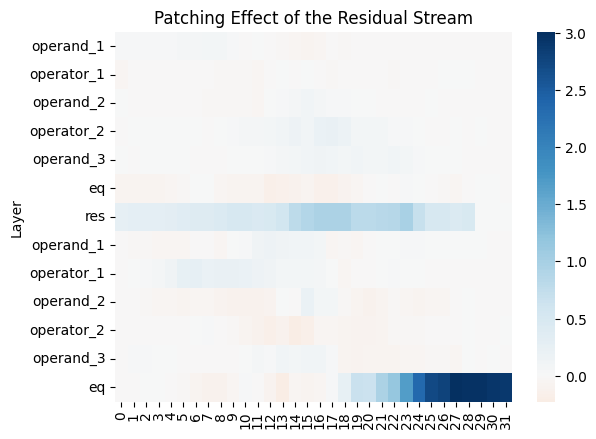

In [54]:
patching_effect = compute_pe(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs)
plt.figure()
sns.heatmap(
    patching_effect.T,
    cmap='RdBu',
    vmin=torch.min(patching_effect),
    vmax=torch.max(patching_effect),
    yticklabels=LABELS,
    annot=False,
    xticklabels=True,
    center=0
)

plt.title('Patching Effect of the Residual Stream')
plt.ylabel('Layer')
plt.show()

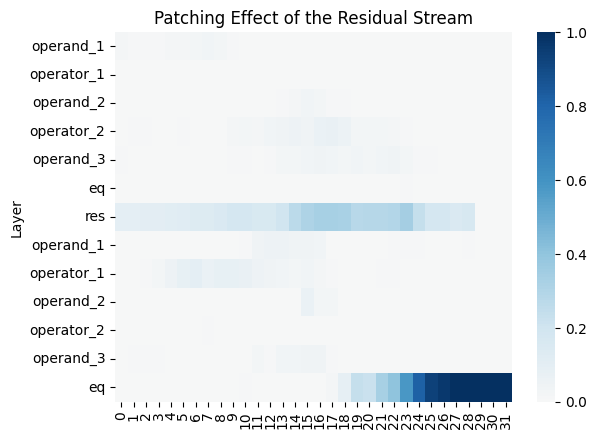

In [55]:
patching_effect = compute_macro_mean(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs)
plt.figure()
sns.heatmap(
    patching_effect.T,
    cmap='RdBu',
    vmin=0,
    vmax=1,
    yticklabels=LABELS,
    annot=False,
    xticklabels=True,
    center=0
)

plt.title('Patching Effect of the Residual Stream')
plt.ylabel('Layer')
plt.show()

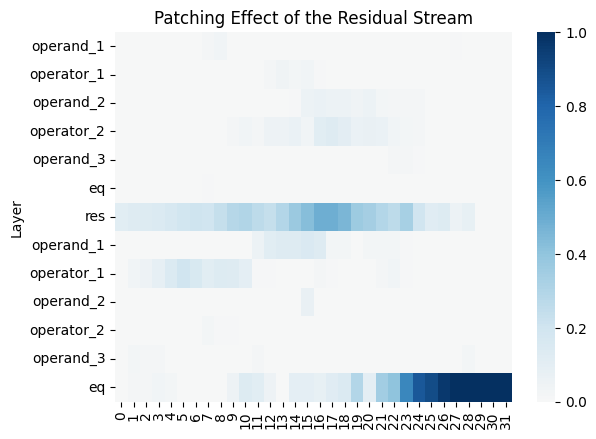

In [56]:
patching_effect = compute_micro_mean(patched_results_operands_operators, all_resid_pre_clean_logit_diffs, all_resid_pre_corrupted_logit_diffs)
plt.figure()
sns.heatmap(
    patching_effect.T,
    cmap='RdBu',
    vmin=0,
    vmax=1,
    yticklabels=LABELS,
    annot=False,
    xticklabels=True,
    center=0
)

plt.title('Patching Effect of the Residual Stream')
plt.ylabel('Layer')
plt.show()